# Notebook configuration

In [3]:
import glob

run_number    = 4482
inputfiles = glob.glob("/Users/ansimez/Documents/InvCit/hdf5/{}/pmaps/pmaps*.root.h5".format(run_number))

# Dorothea cut analysis

In [33]:
import os
import functools
import time
print("Running on ", time.asctime())

import numpy             as np
import tables            as tb
import matplotlib.pyplot as plt

#import invisible_cities.core.core_functions as coref
#import invisible_cities.core.fit_functions  as fitf
import invisible_cities.reco.pmaps_functions  as pmapsf
import invisible_cities.filters.s1s2_filter as s1s2filt

from invisible_cities.reco.tbl_functions     import get_event_numbers_and_timestamps_from_file_name
from invisible_cities.core.system_of_units_c import units

#from icaro.core.hst_functions import hist
##from icaro.core.hst_functions import hist2d
#from icaro.core.hst_functions import pdf
#from icaro.core.hst_functions import labels
#from icaro.core.hst_functions import hist2d_profile
#from icaro.core.hst_functions import covariance
#from icaro.core.hst_functions import resolution
#from icaro.core.hst_functions import gausstext
#from icaro.core.hst_functions import shift_to_bin_centers
#from icaro.core.hst_functions import save_to_folder

#pi   = np.pi
#save = functools.partial(save_to_folder, outputfolder) if save_plots else lambda *x: None

Running on  Thu Jul 13 19:27:00 2017


#### General plotting options

In [5]:
%matplotlib inline

np.warnings.filterwarnings('ignore')

plt.rcParams["figure.figsize"]          = 8, 6
plt.rcParams["font.size"]               = 15
plt.rcParams["figure.max_open_warning"] = 100

profOpt = "--k"
fitOpt  = "r"
if not os.path.exists(outputfolder):
    os.mkdir(outputfolder)

#### Function to select number of peaks

In [68]:
def select_peaks(select, s1_all, s2_all, s2si_all):
    nevt_out = 0
    s1_cut = {}
    s2_cut = {}
    s2si_cut = {}
    for evt in s1_all:
        if not s1s2filt.s1s2_filter(select, s1_all[evt], s2_all[evt], s2si_all[evt]):
            continue
        s2_cut_dummy, s2si_cut_dummy = select.select_S2(s2_all[evt], s2si_all[evt])
        s1_cut[evt] = select.select_S1(s1_all[evt])
        s2_cut[evt] = s2_cut_dummy
        s2si_cut[evt] = s2si_cut_dummy
        nevt_out += 1
    return nevt_out, s1_cut, s2_cut, s2si_cut

# Read data

In [69]:
s1_all = {}
s2_all = {}
s2si_all = {}

n_s1 = 0
n_s2 = 0
n_s2si = 0
n_common = 0
n_some = 0
n_function = 0

for file in inputfiles[:50]:
    s1_file, s2_file, s2si_file = pmapsf.load_pmaps(file)
    n_s1 += len(s1_file)
    n_s2 += len(s2_file)
    n_s2si += len(s2si_file)
    someS12_events = set(s1_file.keys()) | set(s2_file.keys()) | set(s2si_file.keys())
    common_events = set(s1_file.keys()) & set(s2_file.keys()) & set(s2si_file.keys())
    n_some += len(someS12_events)
    n_common += len(common_events)
    n_function += len(get_event_numbers_and_timestamps_from_file_name(file)[0])
    s1_all.update({k:v for k,v in s1_file.items() if k in common_events})
    s2_all.update({k:v for k,v in s2_file.items() if k in common_events})
    s2si_all.update({k:v for k,v in s2si_file.items() if k in common_events})

In [70]:
print("Events with S1: {}".format(n_s1))
print("Events with S2: {}".format(n_s2))
print("Events with S2si: {}".format(n_s2si))
print("Events with all: {}".format(n_common))
print("Events with any: {}".format(n_some))
print("Events from file: {}".format(n_function))

Events with S1: 2209
Events with S2: 2014
Events with S2si: 1982
Events with all: 1940
Events with any: 2252
Events from file: 2326


#### Base selector with Dorothea cut parameters

In [165]:
s1_emin = 100.
s1_emax = 1000.
s1_wmin = 8
s1_wmax = 30
s1_hmin = 40.
s1_hmax = 300.
s1_num = 1
s1_ethr = 5.

s2_emin = 2000.
s2_emax = 10000000.
s2_wmin = 5.
s2_wmax = 1000.
s2_hmin = 1.
s2_hmax = 100000.
s2_numMin = 1
s2_numMax = 10
s2_ethr = 2.
s2_nsipmmin = 1
s2_nsipmmax = 1800

def refresh_selector():
    s1_emin = 100.
    s1_emax = 1000.
    s1_wmin = 8
    s1_wmax = 30
    s1_hmin = 40.
    s1_hmax = 300.
    s1_num = 1
    s1_ethr = 5.

    s2_emin = 2000.
    s2_emax = 10000000.
    s2_wmin = 5.
    s2_wmax = 1000.
    s2_hmin = 1.
    s2_hmax = 100000.
    s2_numMin = 1
    s2_numMax = 10
    s2_ethr = 2.
    s2_nsipmmin = 1
    s2_nsipmmax = 1800

    selector = s1s2filt.S12Selector(s1_nmin = s1_num, s1_nmax = s1_num, s1_emin = s1_emin, s1_emax = s1_emax, s1_ethr = s1_ethr,
                                    s1_lmin = s1_wmin, s1_lmax = s1_wmax, s1_hmin = s1_hmin, s1_hmax = s1_hmax,
                                    s2_nmin = s2_numMin, s2_nmax = s2_numMax, s2_emin = s2_emin, s2_emax = s2_emax, 
                                    s2_lmin = s2_wmin, s2_lmax = s2_wmax, s2_hmin = s2_hmin, s2_hmax = s2_hmax, 
                                    s2_nsipmmin = s2_nsipmmin, s2_nsipmmax = s2_nsipmmax, s2_ethr = s2_ethr)

    return selector

In [76]:
print(selector.S1_Emin)
n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
print("N events total = {}".format(len(s1_all)))
print("N events passed = {}".format(n_out))


100.0
N events total = 1940
N events passed = 1705


# Cut studies

### General efficiency function

In [ ]:
#def efficiency(var_min, var_max, step, n_total):
#    selector = refresh_selector()
#    var = np.arange(var_min, var_max, step)
#    
#    for w in var:
#        selector.S1_Lmin = w ¿COMO PASAR EL CAMPO? PREGUNTAR
#        n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
#    eff.append(n_out/n_total)

#### Variable to save maximum values

In [127]:
max_val = {}

## S1 cuts

### S1 min width

Maximum efficiency of 0.8829896907216495 at 9


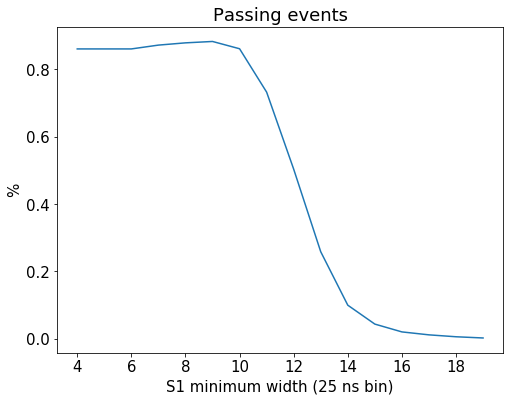

In [170]:
selector = refresh_selector()
var_min = 4
var_max = 20
step = 1
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S1_Lmin = w
    n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S1 minimum width (25 ns bin)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s1_wmin"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S1 max width

Maximum efficiency of 0.8809278350515464 at 18


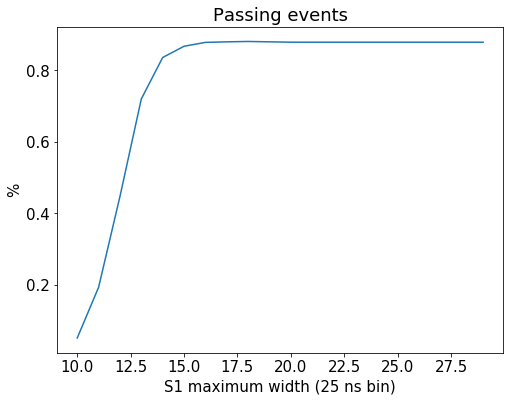

In [174]:
selector = refresh_selector()
var_min = 10
var_max = 30
step = 1
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S1_Lmax = w
    n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S1 maximum width (25 ns bin)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s1_wmax"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S1 min E

Maximum efficiency of 0.8788659793814433 at 0


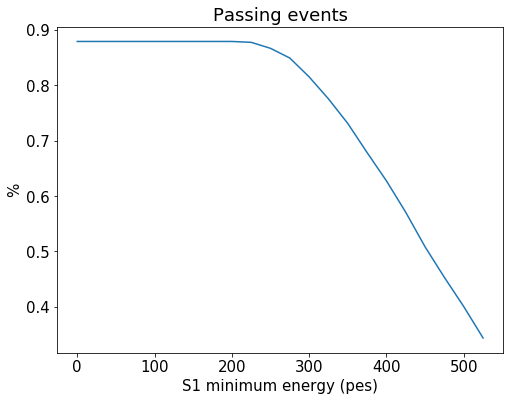

In [155]:
selector = refresh_selector()
var_min = 0
var_max = 550
step = 25
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S1_Emin = w
    n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S1 minimum energy (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s1_emin"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S1 max E

Maximum efficiency of 0.8793814432989691 at 900


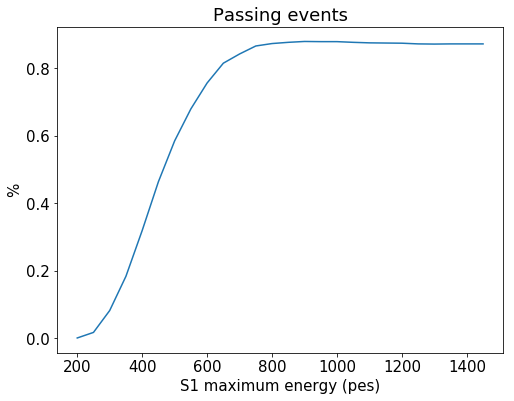

In [156]:
selector = refresh_selector()
var_min = 200
var_max = 1500
step = 50
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S1_Emax = w
    n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S1 maximum energy (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s1_emax"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S1 min H

Maximum efficiency of 0.8798969072164948 at 42.0


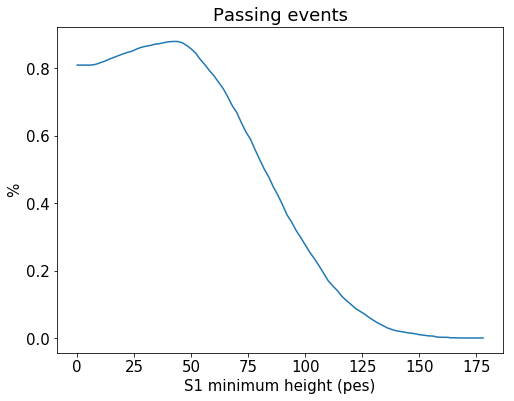

In [157]:
selector = refresh_selector()
var_min = 0.
var_max = 180.
step = 2.
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S1_Hmin = w
    n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S1 minimum height (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s1_hmin"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S1 max H

Maximum efficiency of 0.8793814432989691 at 165.0


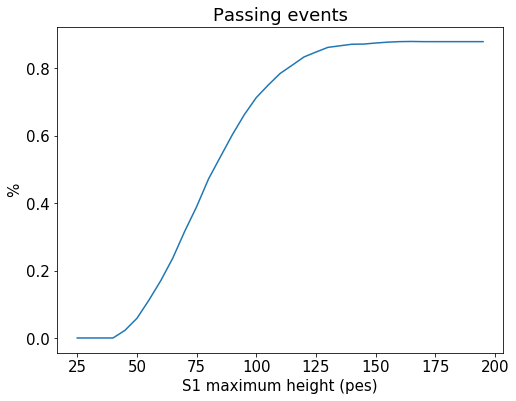

In [158]:
selector = refresh_selector()
var_min = 25.
var_max = 200.
step = 5.
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S1_Hmax = w
    n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S1 maximum height (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s1_hmax"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S1 E thr

Maximum efficiency of 0.8788659793814433 at 0.0


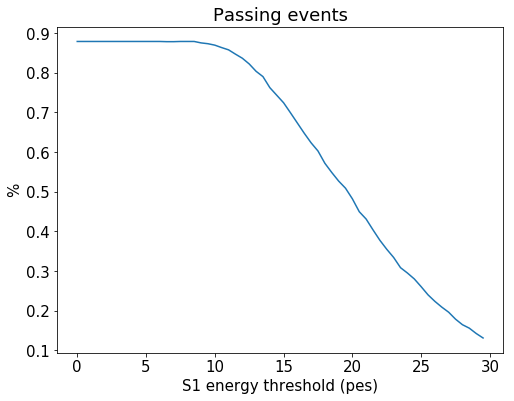

In [159]:
selector = refresh_selector()
var_min = 0.
var_max = 30.
step = 0.5
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S1_Ethr = w
    n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S1 energy threshold (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s1_ethr"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### Efficiency with S1 max args

In [176]:
selector = s1s2filt.S12Selector(s1_nmin = 1, s1_nmax = 1, s1_emin = max_val["s1_emin"], s1_emax = max_val["s1_emax"], 
                                s1_ethr = max_val["s1_ethr"], s1_lmin = max_val["s1_wmin"], s1_lmax = max_val["s1_wmax"], 
                                s1_hmin = max_val["s1_hmin"], s1_hmax = max_val["s1_hmax"],
                                s2_nmin = s2_numMin, s2_nmax = s2_numMax, s2_emin = s2_emin, s2_emax = s2_emax, 
                                s2_lmin = s2_wmin, s2_lmax = s2_wmax, s2_hmin = s2_hmin, s2_hmax = s2_hmax, 
                                s2_nsipmmin = s2_nsipmmin, s2_nsipmmax = s2_nsipmmax, s2_ethr = s2_ethr)

n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)

print("S1 max args: {}".format(max_val))

print("Efficiency with S1 max args: {}".format(n_out/len(s1_all)))

S1 max args: {'s1_wmin': 9, 's1_wmax': 18, 's1_emin': 0, 's1_emax': 900, 's1_hmin': 42.0, 's1_hmax': 165.0, 's1_ethr': 0.0, 's2_wmin': 0.0, 's2_wmax': 1000.0}
Efficiency with S1 max args: 0.8855670103092783


## S2 cuts

### S2 min width

Maximum efficiency of 0.8788659793814433 at 0.0


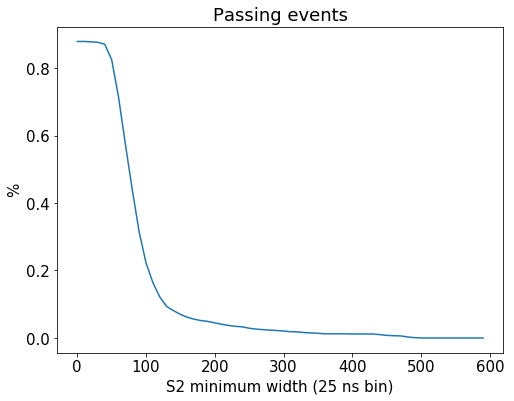

In [173]:
selector = refresh_selector()
var_min = 0.
var_max = 600.
step = 10.
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_Lmin = w
    n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 minimum width (25 ns bin)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_wmin"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S2 max width

Maximum efficiency of 0.8788659793814433 at 500.0


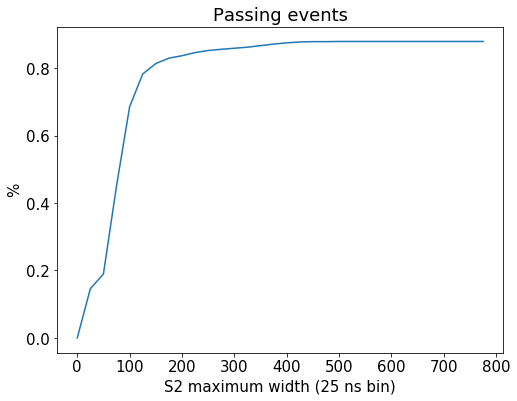

In [179]:
selector = refresh_selector()
var_min = 0.
var_max = 800.
step = 25.
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_Lmax = w
    n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 maximum width (25 ns bin)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_wmax"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S2 min E

Maximum efficiency of 0.8788659793814433 at 0.0


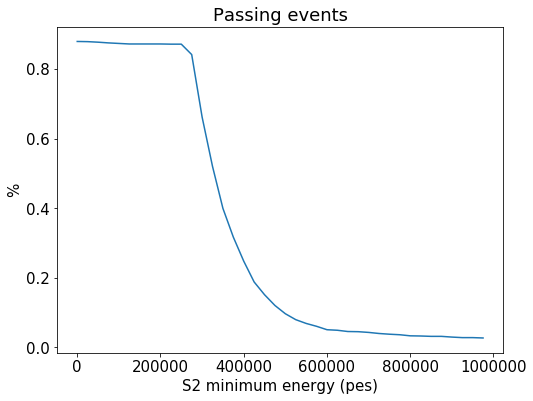

In [182]:
selector = refresh_selector()
var_min = 0
var_max = 1e6
step = 0.25e5
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_Emin = w
    n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 minimum energy (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_emin"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S2 max E

Maximum efficiency of 0.8608247422680413 at 975000.0


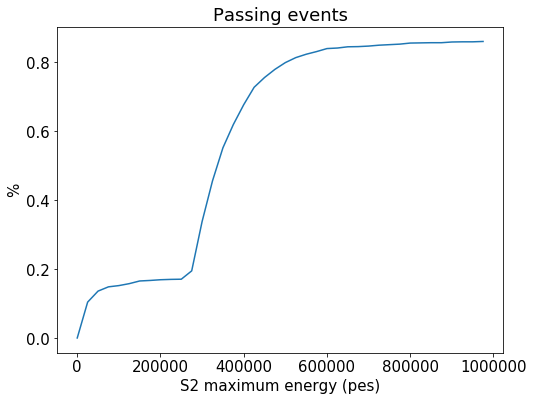

In [184]:
selector = refresh_selector()
var_min = 0
var_max = 1e6
step = 0.25e5
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_Emax = w
    n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 maximum energy (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_emax"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S2 min H

Maximum efficiency of 0.8788659793814433 at 0.0


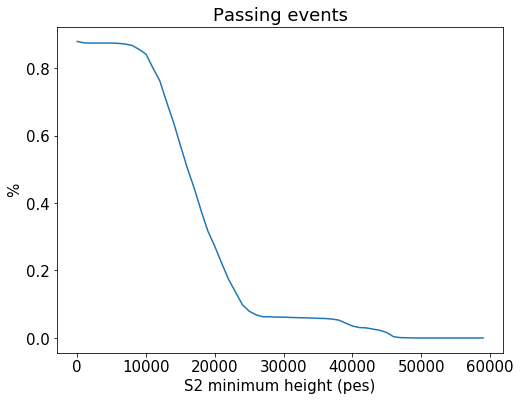

In [187]:
selector = refresh_selector()
var_min = 0.
var_max = 6e4
step = 1e3
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_Hmin = w
    n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 minimum height (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_hmin"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S2 max H

Maximum efficiency of 0.8788659793814433 at 49000.0


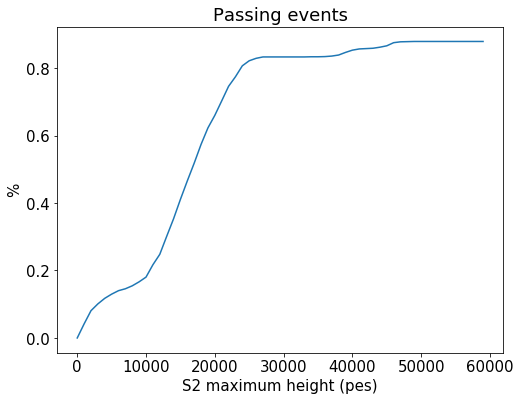

In [191]:
selector = refresh_selector()
var_min = 0.
var_max = 6e4
step = 1e3
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_Hmax = w
    n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 maximum height (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_hmax"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S2 E thr

Maximum efficiency of 0.8788659793814433 at 0.0


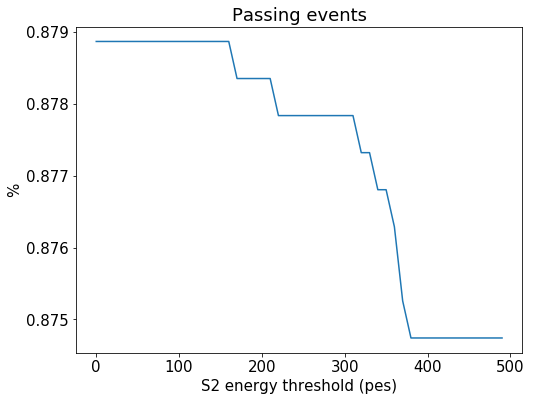

In [216]:
selector = refresh_selector()
var_min = 0.
var_max = 500.
step = 10.
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_Ethr = w
    n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 energy threshold (pes)')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_ethr"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S2 N SiPM min 

Maximum efficiency of 0.8788659793814433 at 0.0


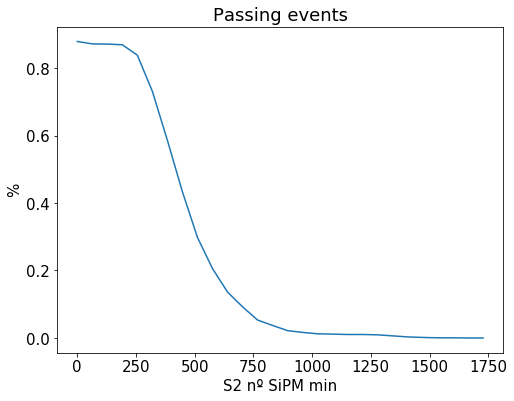

In [212]:
selector = refresh_selector()
var_min = 0.
var_max = 1792.
step = 64.
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_NSIPMmin = w
    n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 nº SiPM min')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_nsipmmin"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### S2 N SiPM max

Maximum efficiency of 0.8788659793814433 at 1536.0


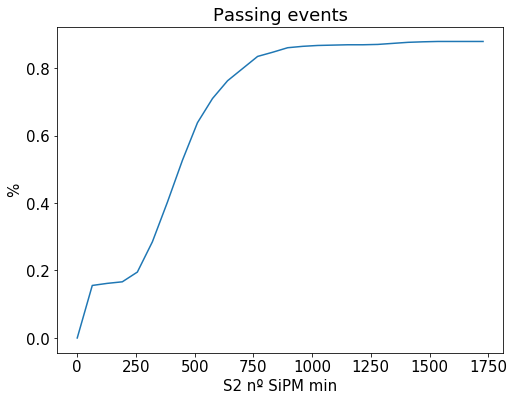

In [213]:
selector = refresh_selector()
var_min = 0.
var_max = 1792.
step = 64.
var = np.arange(var_min,var_max,step)
n_total = len(s1_all)
eff = []

for w in var:
    selector.S2_NSIPMmax = w
    n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)
    eff.append(n_out/n_total)
    
plt.plot(var, eff)
plt.xlabel('S2 nº SiPM min')
plt.ylabel('%')
plt.title("Passing events")

max_val["s2_nsipmmax"] = var[np.argmax(eff)]
print("Maximum efficiency of {} at {}".format(np.max(eff), var[np.argmax(eff)]))

### Efficiency with S2 max args

In [217]:
selector = s1s2filt.S12Selector(s1_nmin = 1, s1_nmax = 1, s1_emin = s1_emin, s1_emax = s1_emax, 
                                s1_ethr = s1_ethr, s1_lmin = s1_wmin, s1_lmax = s1_wmax, 
                                s1_hmin = s1_hmin, s1_hmax = s1_hmax,
                                s2_nmin = 1, s2_nmax = 10, s2_emin = max_val["s2_emin"], s2_emax = max_val["s2_emax"], 
                                s2_lmin = max_val["s2_wmin"], s2_lmax = max_val["s2_wmax"], s2_hmin = max_val["s2_hmin"],
                                s2_hmax = max_val["s2_hmax"], s2_nsipmmin = 1, 
                                s2_nsipmmax = 1800, s2_ethr = max_val["s2_ethr"])

n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)

print("Max args: {}".format(max_val))

print("Efficiency with S2 max args: {}".format(n_out/len(s1_all)))

Max args: {'s1_wmin': 9, 's1_wmax': 18, 's1_emin': 0, 's1_emax': 900, 's1_hmin': 42.0, 's1_hmax': 165.0, 's1_ethr': 0.0, 's2_wmin': 0.0, 's2_wmax': 500.0, 's2_emin': 0.0, 's2_emax': 975000.0, 's2_hmin': 0.0, 's2_hmax': 49000.0, 's2_ethr': 0.0, 's2_nsipmmin': 0.0, 's2_nsipmmax': 1536.0}
Efficiency with S2 max args: 0.8608247422680413


### Efficiency with all max args

In [218]:
selector = s1s2filt.S12Selector(s1_nmin = 1, s1_nmax = 1, s1_emin = max_val["s1_emin"], s1_emax = max_val["s1_emax"], 
                                s1_ethr = max_val["s1_ethr"], s1_lmin = max_val["s1_wmin"], s1_lmax = max_val["s1_wmax"], 
                                s1_hmin = max_val["s1_hmin"], s1_hmax = max_val["s1_hmax"],
                                s2_nmin = 1, s2_nmax = 10, s2_emin = max_val["s2_emin"], s2_emax = max_val["s2_emax"], 
                                s2_lmin = max_val["s2_wmin"], s2_lmax = max_val["s2_wmax"], s2_hmin = max_val["s2_hmin"],
                                s2_hmax = max_val["s2_hmax"], s2_nsipmmin = 1, 
                                s2_nsipmmax = 1800, s2_ethr = max_val["s2_ethr"])

n_out, s1_cut, s2_cut, s2si_cut = select_peaks(selector, s1_all, s2_all, s2si_all)

print("Max args: {}".format(max_val))

print("Efficiency with all max args: {}".format(n_out/len(s1_all)))

Max args: {'s1_wmin': 9, 's1_wmax': 18, 's1_emin': 0, 's1_emax': 900, 's1_hmin': 42.0, 's1_hmax': 165.0, 's1_ethr': 0.0, 's2_wmin': 0.0, 's2_wmax': 500.0, 's2_emin': 0.0, 's2_emax': 975000.0, 's2_hmin': 0.0, 's2_hmax': 49000.0, 's2_ethr': 0.0, 's2_nsipmmin': 0.0, 's2_nsipmmax': 1536.0}
Efficiency with all max args: 0.8675257731958763
